# I70 Traffic Predictor
---

### The goal of this project is to be able to predict the amount of cars that will pass by a traffic measuring station along I70 for a given hour of a day

We are using data from NOAA (National Oceanic and Atmospheric Administration) for daily snow totals and daily snow depth from a measuring station in Winter Park, Colorado, as well as data from CDOT (Colorado Department of Transportation) with a counter of how many cars pass by the station (count station 000120 on I70 right before Idaho Springs)

In [29]:
import numpy as np
import random
import sklearn
import math
import matplotlib.pyplot as plt
import pandas as pd
import data
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [30]:
def transform_data_one_year(traffic_data, snow_depth_data, daily_snow_data):
    '''
    Function to return a transformed dataframe of a year's worth of data
    :param traffic_data: The traffic dataframe for a given year, exported from CDOT
    :param snow_depth_data: The snow depth dataframe for the same year, from NOAA
    :param daily_snow_data: The daily snow datafram fro the same year, from NOAA
    :return: A single, formatted dataframe containing all of the information from the parameters
    '''
    # Replace all invalid data with 0s
    daily_snow_data.replace("T", 0, inplace=True)
    daily_snow_data.replace("T", 0, inplace=True)
    daily_snow_data.replace("M", 0, inplace=True)
    daily_snow_data.replace("M", 0, inplace=True)
    # Only care about secondary direction
    # drop rows where COUNTDIR != 'S'
    traffic_data = traffic_data[traffic_data['COUNTDIR'] == 'S']
    df = pd.DataFrame()
    # temp arrays so we can store them in the datafram
    temp_month = []
    temp_day = []
    temp_year = []
    temp_dow = []
    temp_hour = []
    temp_snow_depth = []
    temp_daily_snow = []
    temp_count = []
    
    # iterate through every hour of every day and get the data for it
    for i, date in enumerate(traffic_data['FormattedDate']):
        for j in range(24):
            temp_count.append(traffic_data.iloc[i]['HOUR' + str(j)])
            temp_hour.append(j)
            month = datetime.strptime(date, "%m/%d/%Y").month
            day = datetime.strptime(date, "%m/%d/%Y").day
            year = datetime.strptime(date, "%m/%d/%Y").year
            dow = datetime(year, month, day).weekday()
            temp_month.append(month)
            temp_day.append(day)
            temp_year.append(year)
            temp_dow.append(dow)
            temp_snow_depth.append(float(snow_depth_data.iloc[day-1][calendar.month_abbr[month]]))
            temp_daily_snow.append(float(daily_snow_data.iloc[day-1][calendar.month_abbr[month]]))
            
    # finally create the dataframe
    df['MONTH'] = temp_month
    df['YEAR'] = temp_year
    df['DAY'] = temp_day
    df['DOW'] = temp_dow
    df['HOUR'] = temp_hour
    df['SNOW_DEPTH'] = temp_snow_depth
    df['DAILY_SNOW'] = temp_daily_snow
    df['COUNT'] = temp_count

    return df
    
# Create the dataframe for 2019
snow_depth19 = pd.read_csv("data/2019WinterParkSnowDepth.csv")
daily_snow19 = pd.read_csv("data/2019WinterParkDailySnow.csv")
traffic19 = pd.read_csv("data/AnnualTrafficVolume2019.csv")
df1 = transform_data_one_year(traffic19, snow_depth19, daily_snow19)

# Create the dataframe for 2020
snow_depth20 = pd.read_csv("data/2020WinterParkSnowDepth.csv")
daily_snow20 = pd.read_csv("data/2020WinterParkDailySnow.csv")
traffic20 = pd.read_csv("data/AnnualTrafficVolume2020.csv")
df2 = transform_data_one_year(traffic20, snow_depth20, daily_snow20)

# Create the dataframe for 2021
snow_depth21 = pd.read_csv("data/2021WinterParkSnowDepth.csv")
daily_snow21 = pd.read_csv("data/2021WinterParkDailySnow.csv")
traffic21 = pd.read_csv("data/AnnualTrafficVolume2021.csv")
df3 = transform_data_one_year(traffic21, snow_depth21, daily_snow21)

# Create the dataframe for 2022
snow_depth22 = pd.read_csv("data/2022WinterParkSnowDepth.csv")
daily_snow22 = pd.read_csv("data/2022WinterParkDailySnow.csv")
traffic22 = pd.read_csv("data/AnnualTrafficVolume2022.csv")
df4 = transform_data_one_year(traffic22, snow_depth22, daily_snow22)

# concatenate the dataframes
frames = [df1, df2, df3, df4]
full_dataframe = pd.concat(frames)
full_dataframe.dtypes

MONTH           int64
YEAR            int64
DAY             int64
DOW             int64
HOUR            int64
SNOW_DEPTH    float64
DAILY_SNOW    float64
COUNT           int64
dtype: object

In [33]:
np_data = full_dataframe
X = full_dataframe.iloc[:,:-1]
y = full_dataframe.iloc[:,-1]
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

def scale_datasets(x_train, x_test):

    """
    Standard Scale test and train data
    Z - Score normalization
    """
    standard_scaler = StandardScaler()
    x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
    )
    x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
    )
    return x_train_scaled, x_test_scaled

x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)

hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
    model = Sequential([
        Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
        Dropout(0.2),
        Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
        Dropout(0.2),
        Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
        Dense(1, kernel_initializer='normal', activation='linear')
    ])
    return model
# build the model
model = build_model_using_sequential()

# loss function
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle]
)
# train the model
history = model.fit(
    x_train_scaled, 
    y_train, 
    epochs=20, 
    batch_size=64,
    validation_split=0.2
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


320/320 [==============================] - 2s 4ms/step - loss: 1.4174 - mean_squared_logarithmic_error: 1.4173 - val_loss: 0.9470 - val_mean_squared_logarithmic_error: 0.9470
Epoch 2/20
320/320 [==============================] - 1s 3ms/step - loss: 0.6794 - mean_squared_logarithmic_error: 0.6793 - val_loss: 0.2170 - val_mean_squared_logarithmic_error: 0.2170
Epoch 3/20
320/320 [==============================] - 1s 4ms/step - loss: 0.2443 - mean_squared_logarithmic_error: 0.2442 - val_loss: 0.1635 - val_mean_squared_logarithmic_error: 0.1635
Epoch 4/20
320/320 [==============================] - 1s 4ms/step - loss: 0.2047 - mean_squared_logarithmic_error: 0.2047 - val_loss: 0.1537 - val_mean_squared_logarithmic_error: 0.1537
Epoch 5/20
320/320 [==============================] - 1s 3ms/step - loss: 0.1893 - mean_squared_logarithmic_error: 0.1893 - val_loss: 0.1435 - val_mean_squared_logarithmic_error: 0.1435
Epoch 6/20
320/320 [==============================] - 1s 3ms/step - loss: 0.1855 

In [34]:
predictions = model.predict(x_test_scaled)

# random values
min_val = min(y_test)
max_val = max(y_test)
random_values = [random.uniform(min_val, max_val) for _ in y_test]

# tolerances to show for
tolerances = [0.1, 0.15, 0.2, 0.3, 0.4]

for tolerance in tolerances:
    model_count = 0
    random_count = 0
    for i in range(len(predictions)):
        delta = y_test.iloc[i] * tolerance
        if y_test.iloc[i] - delta < predictions[i] and predictions[i] < y_test.iloc[i] + delta:
            model_count += 1
        if y_test.iloc[i] - delta < random_values[i] and random_values[i] < y_test.iloc[i] + delta:
            random_count += 1

    model_score = model_count/len(predictions)
    random_score = random_count/len(predictions)

    print(f'Random score for a tolerance of {tolerance*100}%: {round(random_score, 4)}')
    print(f'Model score for a tolerance of {tolerance*100}%: {round(model_score, 4)}\n')

267/267 [==============================] - 0s 956us/step
Random score for a tolerance of 10.0%: 0.025
Model score for a tolerance of 10.0%: 0.3626

Random score for a tolerance of 15.0%: 0.0363
Model score for a tolerance of 15.0%: 0.5149

Random score for a tolerance of 20.0%: 0.0461
Model score for a tolerance of 20.0%: 0.6433

Random score for a tolerance of 30.0%: 0.0677
Model score for a tolerance of 30.0%: 0.8181

Random score for a tolerance of 40.0%: 0.0906
Model score for a tolerance of 40.0%: 0.9117



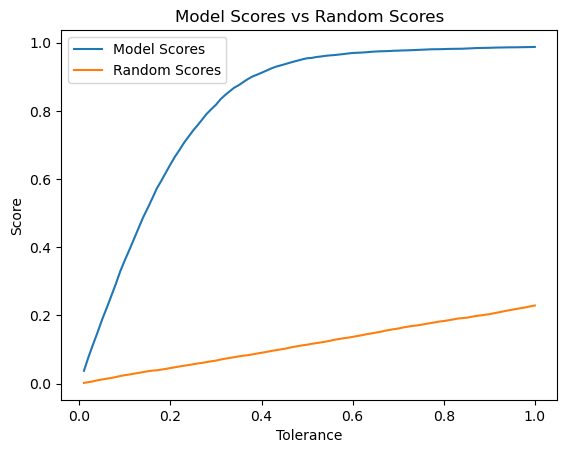

In [35]:
tolerances = np.linspace(0.01, 1, 100)
model_scores = []
random_scores = []

for tolerance in tolerances:
    model_count = 0
    random_count = 0
    for i in range(len(predictions)):
        delta = y_test.iloc[i] * tolerance
        if y_test.iloc[i] - delta < predictions[i] and predictions[i] < y_test.iloc[i] + delta:
            model_count += 1
        if y_test.iloc[i] - delta < random_values[i] and random_values[i] < y_test.iloc[i] + delta:
            random_count += 1
            
    model_scores.append(model_count / len(predictions))
    random_scores.append(random_count / len(predictions))
    
    
plt.plot(tolerances, model_scores, label='Model Scores')
plt.plot(tolerances, random_scores, label='Random Scores')

# Adding labels and title
plt.xlabel('Tolerance')
plt.ylabel('Score')
plt.title('Model Scores vs Random Scores')

# Adding legend
plt.legend()

# Display the plot
plt.show()


In [36]:
# Evaluating model
r2 = r2_score(y_test, predictions)
n = len(x_test_scaled)  # Number of samples
p = x_test_scaled.shape[1]  # Number of predictors

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

mse = mean_squared_error(y_test, predictions)
msle = mean_squared_log_error(y_test, predictions)

print("R-squared:", r2)
print("Adjusted R-squared:", adjusted_r2)
print("Root Mean Squared Logarithmic Error:", np.sqrt(msle))

R-squared: 0.8719040692663718
Adjusted R-squared: 0.871798875517529
Root Mean Squared Logarithmic Error: 0.31510702921487665
